# **Unimelb Assignment 2: Cohort characterisation and clustering**
**Subject: COMP90089_2024_SM2 Machine Learning Applications for Health**

**Student Name:** Zilin Chen

**Overview**

This project aims to explore the main characteristics of the provided patient cohort, identify clusters of patients and evaluate their clinical significance. As input, the project focuses on a cohort of patients with profound hypotension.

The main patient characteristics that the project will use include: Demographics, Co-morbidity index (Charlson), Severity of illness scores (APSIII) as well as patient outcomes, including length of stay (LoS) and in-ICU mortality.


### **Importing Libraries**

Set up the environment

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

!pip install plotly==5.10.0
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
pio.renderers.default = "colab"

### **Loading the Data**

**The Dataset**

The data for this is a subset of patients with hypotension.

In [ ]:
df = pd.read_csv('hypotension_patients.csv', index_col='ID')

**The Hypotension Patient Cohort has the following columns:**

* **“ID”:** Patient de-identified number;

* **“anchor_age”:** Age of the patient (years);

* **“gender”:** F for female and M for male;

* **“dod”:** Date of Death (if empty means survived - patient outcome variable);

* **“apsiii”:** Severity of illness score;

* **“LoS”:** Length of stay in ICU (days - patient outcome variable);

* **“charlson_comorbidity_index”:** Co-morbidity index.

In [ ]:
df.head(10)

,anchor_age,gender,dod,apsiii,LoS,charlson_comorbidity_index
ID,,,,,,
1,80,F,NaN,56,7.00,4
2,72,F,2137-09-02,49,12.92,6
3,82,M,2144-06-18,46,13.13,5
4,89,F,2155-12-07,86,4.92,7
5,69,F,2136-05-12,102,11.46,8
6,64,F,2185-10-09,88,9.96,10
7,60,F,NaN,50,2.54,3
8,87,M,2177-03-29,58,1.17,10
9,63,M,NaN,35,39.83,4


In [ ]:
# Discover the dimensions of the DataFrame in the format (number of rows, number of columns).
df.shape

(5106, 6)

In [ ]:
# Discover the data type of the DataFrame
df.dtypes

,0
anchor_age,int64
gender,object
dod,object
apsiii,int64
LoS,float64
charlson_comorbidity_index,int64


# **Data Preparation**

In [ ]:
# Convert the values in the 'dod' column of the DataFrame df into a datetime format
df['dod']=pd.to_datetime(df['dod'])

In [ ]:
# Rename the columns
df = df.rename(columns={'anchor_age':'Age','gender':'Gender','dod':'Date_of_Death','apsiii':'Severity', 'LoS':'ICU_LoS','charlson_comorbidity_index':'Co-morbidity_Index' })


In [ ]:
df.head()

,Age,Gender,Date_of_Death,Severity,ICU_LoS,Co-morbidity_Index
ID,,,,,,
1,80,F,NaT,56,7.00,4
2,72,F,2137-09-02,49,12.92,6
3,82,M,2144-06-18,46,13.13,5
4,89,F,2155-12-07,86,4.92,7
5,69,F,2136-05-12,102,11.46,8


In [ ]:
# Find null value
# For Date_of_Death, if empty means survived
df.isna().sum()

,0
Age,0
Gender,0
Date_of_Death,1816
Severity,0
ICU_LoS,0
Co-morbidity_Index,0


In [ ]:
# Find the potential abnormal data
negative_icu_los = df[df['ICU_LoS'] < 0]
negative_icu_los

,Age,Gender,Date_of_Death,Severity,ICU_LoS,Co-morbidity_Index
ID,,,,,,


In [ ]:
# Find duplicated value
df.loc[df.duplicated()]

,Age,Gender,Date_of_Death,Severity,ICU_LoS,Co-morbidity_Index
ID,,,,,,


Extract specific summary statistics (mean, min, and max) for a subset of columns:

* Age
* Severity
* ICU_LoS
* Co-morbidity_Index



In [ ]:
Description = df.describe().loc[['mean', 'min', 'max'], ['Age', 'Severity', 'ICU_LoS', 'Co-morbidity_Index']]

Description

,Age,Severity,ICU_LoS,Co-morbidity_Index
mean,65.552683,60.314532,7.053651,5.217
min,18.000000,3.000000,0.040000,0.000
max,91.000000,189.000000,103.500000,19.000


# **Finding Feature Relationships**

**Main discovered features:**

1.  The five most common ages within the patient cohort are predominantly over 60 years old, with the top 5 ages 91 (164 individuals), 64 (136 individuals), 72 (135 individuals), 67 (164 individuals), and 70 (1,433 individuals).
2. Males constitute a larger proportion of the cohort than females, making up 55.9% compared to 44.1%.
3. There is a significant correlation between the disease and the age of the patients.
4. The majority of patients exhibit mild (APSIII <50) to moderate (50 <= APSIII <100) severity levels.
5. The most common Charlson Comorbidity Index scores among the patients are 5 (889 individuals), 4 (861 individuals), and 6 (722 individuals).



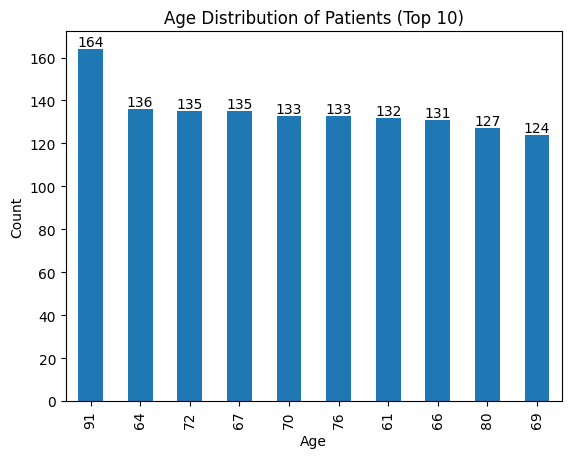

In [ ]:
# Create a bar plot showing the distribution of the top 10 most frequent ages of the patient cohort
ax1= df['Age'].value_counts()\
.head(10)\
.plot(kind='bar', title = 'Age Distribution of Patients (Top 10)')

ax1.set_ylabel('Count')

# Annotate the bars with the value on top of each bar
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

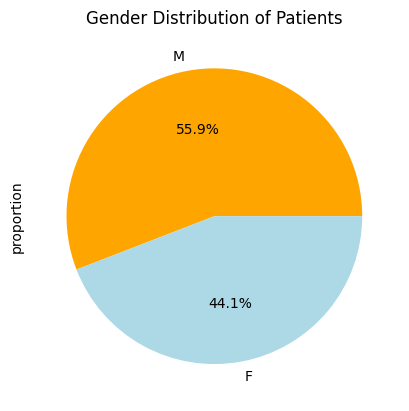

In [ ]:
# Create a pie chart plot showing the distribution of patients' genders
# Count the values of genders and calculate their percentages
gender_counts = df['Gender'].value_counts(normalize=True) * 100

# Modify Colors for the pie chart
colors = ["orange", "lightblue"]  # Assigning colors directly

# Plotting the pie chart with percentages
pie_chart = gender_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, title="Gender Distribution of Patients")

plt.show()

More information about Charlson Comorbidity Index:
[link text](https://www.sciencedirect.com/topics/medicine-and-dentistry/charlson-comorbidity-index)

In [ ]:
# Calculate the number of patients for each Co-morbidity Index
num_patients_df = df.groupby('Co-morbidity_Index').size().reset_index(name='Patient_Count')
num_patients_df

,Co-morbidity_Index,Patient_Count
0,0,149
1,1,195
2,2,351
3,3,521
4,4,861
5,5,889
6,6,722
7,7,530
8,8,356
9,9,222


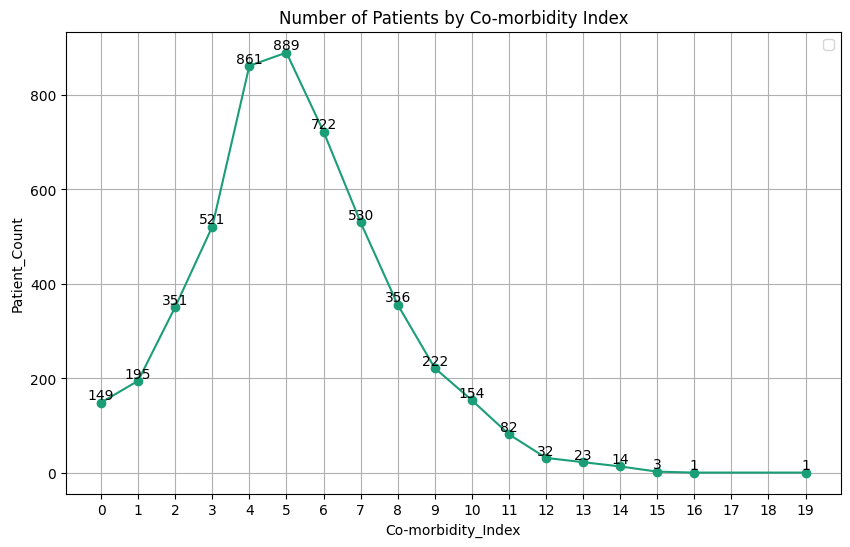

In [ ]:
# Create a line plot showing the distribution of patients' Co-morbidity_Index
# Group patients by Co-morbidity_Index from 0 to 19
grouped_df = df[df['Co-morbidity_Index'].between(0, 19)].groupby('Co-morbidity_Index').size().reset_index(name='Patient_Count')

def _plot_series(series, series_name, series_index=0):
    palette = list(sns.palettes.mpl_palette('Dark2'))
    xs = series['Co-morbidity_Index']
    ys = series['Patient_Count']

    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)], marker='o')

    for x, y in zip(xs, ys):
        plt.text(x, y, str(y), fontsize=10, ha='center', va='bottom')

fig, ax = plt.subplots(figsize=(10, 6))

# Sort the data
df_sorted = grouped_df.sort_values('Co-morbidity_Index', ascending=True)
_plot_series(df_sorted, '')

# Set x-axis to display integers from 0 to 19
plt.xticks(ticks=range(0, 20), labels=range(0, 20))

# Set plot labels
plt.xlabel('Co-morbidity_Index')
plt.ylabel('Patient_Count')
plt.title('Number of Patients by Co-morbidity Index')
plt.legend()
plt.grid(True)
plt.show()


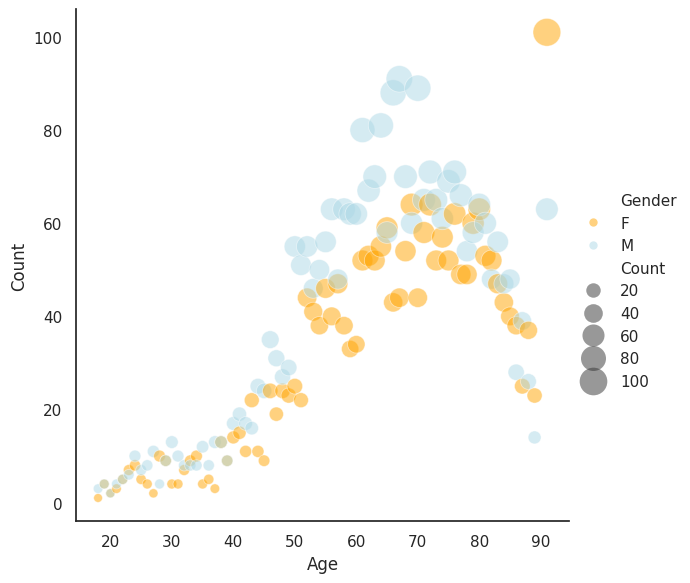

In [ ]:
# Create a  plot showing the distribution of patients' ages and counts
# Calculate the count of each age
age_counts = df.groupby(['Age', 'Gender'])['Age'].count().reset_index(name='Count')

sns.set_theme(style="white")

# Define the color palette for the genders
palette = {"F": "orange", "M": "lightblue"}

# Plot the count of ages
sns.relplot(x="Age", y="Count", hue="Gender", size="Count",
            sizes=(40, 400), alpha=.5, palette=palette,
            height=6, data=age_counts)

plt.show()



In [ ]:
# Define a function to categorize the Severity scores
def categorise_severity(score):
    if score < 50:
        return 'Mild'
    elif 50 <= score < 100:
        return 'Moderate'
    elif 100 <= score < 150:
        return 'Severe'
    else:
        return 'Very Severe'

df['Severity_Category'] = df['Severity'].apply(categorise_severity)
df['Severity_Category']



,Severity_Category
ID,
1,Moderate
2,Mild
3,Mild
4,Moderate
5,Severe
...,...
5102,Moderate
5103,Moderate
5104,Mild


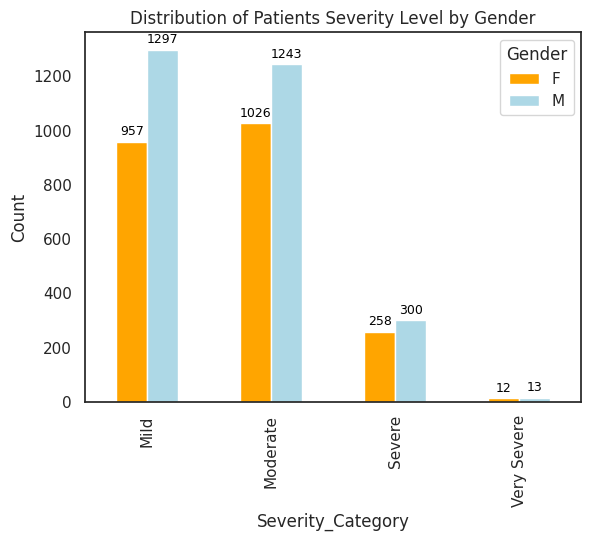

In [ ]:
# Create a bar plot showing the distribution of patients' severity
# Define the color palette for genders
palette = {"F": "orange", "M": "lightblue"}

# Count the number of patients by Severity_Category and Gender
severity_gender_counts = df.groupby(['Severity_Category', 'Gender']).size().unstack()

# Plot the grouped bar chart with gender-separated categories
ax2 = severity_gender_counts.plot(kind='bar', stacked=False, color=[palette['F'], palette['M']], title='Distribution of Patients Severity Level by Gender')

# Set y-axis label
ax2.set_ylabel('Count')

# Annotate each bar with the respective count
for p in ax2.patches:
    ax2.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='baseline', fontsize=9, color='black', xytext=(0, 5),
                 textcoords='offset points')

plt.show()


In [ ]:
# Create a new column 'DoD' where:
# 0 indicates Date_of_Death is not empty (the patient died)
# 1 indicates Date_of_Death is empty (the patient survived)

df['DoD'] = df['Date_of_Death'].apply(lambda x: 1 if pd.isna(x) else 0)

# Display the first few rows to check the result
print(df[['Date_of_Death', 'DoD']].head(10))


   Date_of_Death  DoD
ID                   
1            NaT    1
2     2137-09-02    0
3     2144-06-18    0
4     2155-12-07    0
5     2136-05-12    0
6     2185-10-09    0
7            NaT    1
8     2177-03-29    0
9            NaT    1
10    2155-12-03    0


In [ ]:
# Review the current data frame before next steps
df.head(10)

,Age,Gender,Date_of_Death,Severity,ICU_LoS,Co-morbidity_Index,Severity_Category,DoD
ID,,,,,,,,
1,80,F,NaT,56,7.00,4,Moderate,1
2,72,F,2137-09-02,49,12.92,6,Mild,0
3,82,M,2144-06-18,46,13.13,5,Mild,0
4,89,F,2155-12-07,86,4.92,7,Moderate,0
5,69,F,2136-05-12,102,11.46,8,Severe,0
6,64,F,2185-10-09,88,9.96,10,Moderate,0
7,60,F,NaT,50,2.54,3,Moderate,1
8,87,M,2177-03-29,58,1.17,10,Moderate,0
9,63,M,NaT,35,39.83,4,Mild,1


## **Correlation coefficient between Death and Length of Stay**

**Pearson correlation coefficient:** 0.03294110190100827

**P-value:** 0.018577054318662863

**The data indicates that** ICU Length of Stay is not a strong predictor of whether a patient dies or survives based on this data. Other factors are likely more important in determining patient outcomes.

Pearson correlation coefficient: 0.03294110190100827
P-value: 0.018577054318662863


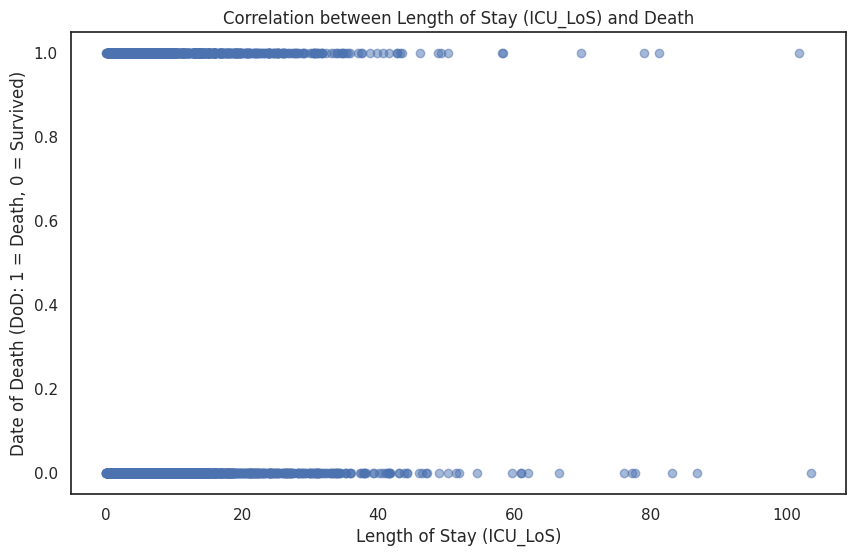

In [ ]:
from scipy.stats import pearsonr

# Calculate the Pearson correlation coefficient between DoD and LoS
correlation, p_value = pearsonr(df['ICU_LoS'], df['DoD'])

# Display the results
print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

# Plot the relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['ICU_LoS'], df['DoD'], alpha=0.5)
plt.title('Correlation between Length of Stay (ICU_LoS) and Death')
plt.xlabel('Length of Stay (ICU_LoS)')
plt.ylabel('Date of Death (DoD: 1 = Death, 0 = Survived)')
plt.show()


## **Correlation coefficient between Death and Severity score**
**Pearson correlation coefficient:** -0.24538014197806185

**P-value:** 6.757565119699496e-71


**Moderate Negative Correlation:** The negative correlation suggests that as the Severity score increases, patients' survival rates improve. If the severity measure is inverted (i.e., higher severity scores represent less severe cases). In conclusion, less severe patients are less likely to die.

Pearson correlation coefficient: -0.24538014197806185
P-value: 6.757565119699496e-71


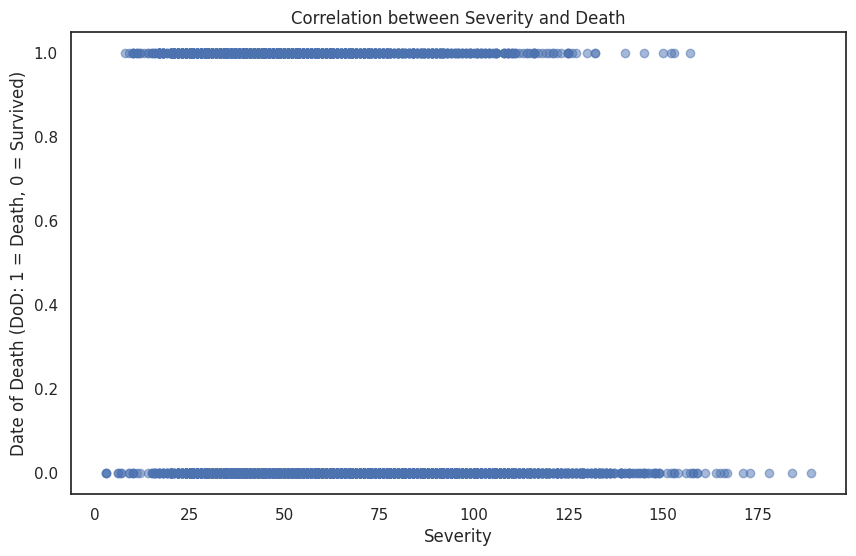

In [ ]:
# Calculate the Pearson correlation coefficient between DoD and Severity
correlation, p_value = pearsonr(df['Severity'], df['DoD'])

# Display the results
print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

# Plot the relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['Severity'], df['DoD'], alpha=0.5)
plt.title('Correlation between Severity and Death')
plt.xlabel('Severity')
plt.ylabel('Date of Death (DoD: 1 = Death, 0 = Survived)')
plt.show()

## **Correlation coefficient between Death and Co-morbidity Index**
**Pearson correlation coefficient:** -0.2413522940760097

**P-value:** 1.4014519164131768e-68

**Moderate Negative Correlation:** There is a moderate negative correlation between the Co-morbidity Index and Date of Death, meaning that patients with higher co-morbidity scores are somewhat more likely to survive. The p-value further indicates that the observed correlation is highly significant and not due to random chance.

**Remark:** This result is counter expectation and it would be helpful to further investigate whether other factors are influencing this unexpected negative relationship.

Pearson correlation coefficient: -0.2413522940760097
P-value: 1.4014519164131768e-68


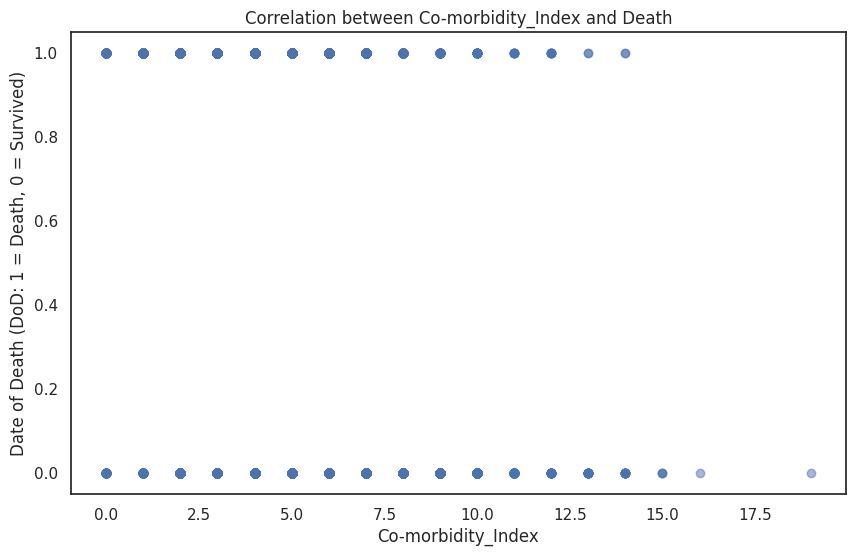

In [ ]:
# Calculate the Pearson correlation coefficient between DoD and Co-morbidity_Index
correlation, p_value = pearsonr(df['Co-morbidity_Index'], df['DoD'])

# Display the results
print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

# Plot the relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['Co-morbidity_Index'], df['DoD'], alpha=0.5)
plt.title('Correlation between Co-morbidity_Index and Death')
plt.xlabel('Co-morbidity_Index')
plt.ylabel('Date of Death (DoD: 1 = Death, 0 = Survived)')
plt.show()

In [ ]:
# Create a new column 'Gender_Binary' where F = 1 and M = 0
df['Gender_Binary'] = df['Gender'].map({'F': 1, 'M': 0})

df.head()

,Age,Gender,Date_of_Death,Severity,ICU_LoS,Co-morbidity_Index,Severity_Category,DoD,Gender_Binary
ID,,,,,,,,,
1,80,F,NaT,56,7.00,4,Moderate,1,1
2,72,F,2137-09-02,49,12.92,6,Mild,0,1
3,82,M,2144-06-18,46,13.13,5,Mild,0,0
4,89,F,2155-12-07,86,4.92,7,Moderate,0,1
5,69,F,2136-05-12,102,11.46,8,Severe,0,1


## **Correlation coefficient between Death and Gender**
**Pearson correlation coefficient:** -0.028262649364651917

**P-value:** 0.04344018778483337

**Very weak negative correlation:** The correlation coefficient is -0.0283, indicating a very weak negative correlation between the Gender_Binary variable (where F = 1 and M = 0) and the Date of Death (DoD) (where DoD = 1 means death, and DoD = 0 means survival).

A negative correlation suggests that being female (since F = 1) is very weakly associated with a lower likelihood of death compared to being male (M = 0). However, because the correlation is very close to 0.

**Remark:** The effect of Gender factor is minimal in this dataset.


Pearson correlation coefficient: -0.028262649364651917
P-value: 0.04344018778483337


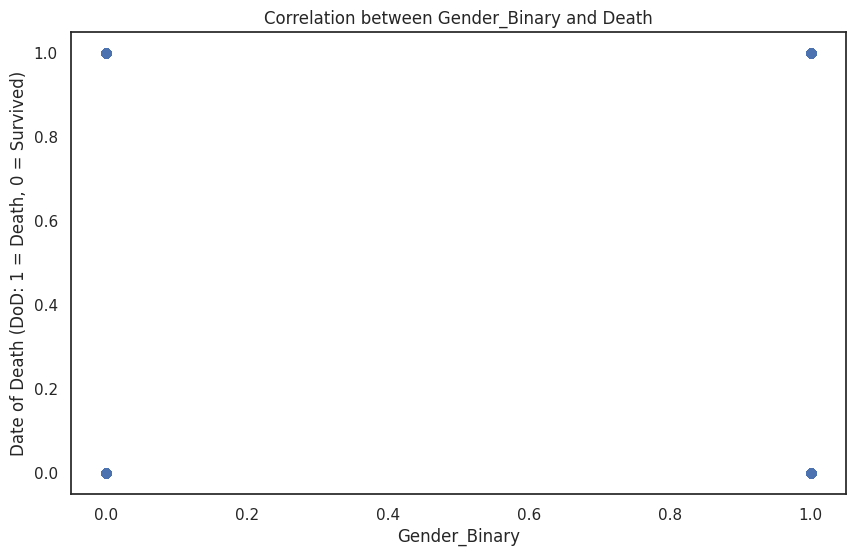

In [ ]:
# Calculate the Pearson correlation coefficient between DoD and Gender_Binary
correlation, p_value = pearsonr(df['Gender_Binary'], df['DoD'])

# Display the results
print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

# Plot the relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['Gender_Binary'], df['DoD'], alpha=0.5)
plt.title('Correlation between Gender_Binary and Death')
plt.xlabel('Gender_Binary')
plt.ylabel('Date of Death (DoD: 1 = Death, 0 = Survived)')
plt.show()

## **Correlation coefficient between Death and Age**

**Pearson correlation coefficient:** -0.17250501669516516

**P-value:** 2.1202806113667698e-35

**Moderate Negative Correlation:** There is a moderate negative correlation between Age and Date of Death (DoD). This suggests that younger patients are slightly more likely to die compared to older patients in this dataset. This might be an unexpected result and could indicate that other factors (such as the type or severity of illness) are influencing mortality more in younger populations, or that older patients might be receiving more aggressive or targeted care. The very small p-value indicates that this correlation is statistically significant, meaning there is a real relationship between age and death, though it is not particularly strong.

Pearson correlation coefficient: -0.17250501669516516
P-value: 2.1202806113667698e-35


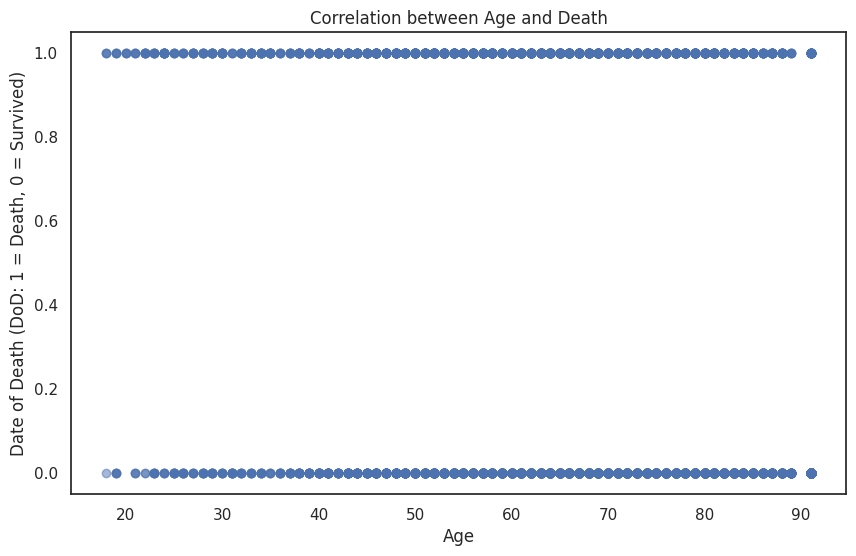

In [ ]:
# Calculate the Pearson correlation coefficient between DoD and Age
correlation, p_value = pearsonr(df['Age'], df['DoD'])

# Display the results
print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

# Plot the relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['Age'], df['DoD'], alpha=0.5)
plt.title('Correlation between Age and Death')
plt.xlabel('Age')
plt.ylabel('Date of Death (DoD: 1 = Death, 0 = Survived)')
plt.show()

# **Perform K-means Clustering to Identify Subgroups of Patients**



Main **Parameters** of the K-Means Function:

**n_clusters** = the number of desired clusters.

**init** = is the method for initialisation. (the default is ‘k-means++’, can also be ‘random’)

**n_init** = how many times to run the k-means clustering algorithms independently with different random centroids to choose the final model (minimising the intra-cluster Sum of Squared Errors(SSE)).

**max_iter** =  the maximum number of iterations for each single run.


**Manage Final Data Set**
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4896734/

The study suggests that gender differences are not significant enough to account for variations in hypertension. Thus, **gender** will not be included as a factor in the final dataset used for K-means clustering.

## **Prepare the data set for the K-means Clustering**

In [ ]:
df.head(10)

,Age,Gender,Date_of_Death,Severity,ICU_LoS,Co-morbidity_Index,Severity_Category,DoD,Gender_Binary
ID,,,,,,,,,
1,80,F,NaT,56,7.00,4,Moderate,1,1
2,72,F,2137-09-02,49,12.92,6,Mild,0,1
3,82,M,2144-06-18,46,13.13,5,Mild,0,0
4,89,F,2155-12-07,86,4.92,7,Moderate,0,1
5,69,F,2136-05-12,102,11.46,8,Severe,0,1
6,64,F,2185-10-09,88,9.96,10,Moderate,0,1
7,60,F,NaT,50,2.54,3,Moderate,1,1
8,87,M,2177-03-29,58,1.17,10,Moderate,0,0
9,63,M,NaT,35,39.83,4,Mild,1,0


In [ ]:
# Drop the data has a weak correlation with the patients' outcomes.
# Final Data set to work with (Only includes Age, Severity and Co-morbidity_Index):
dataset = df.drop(['Date_of_Death', 'Gender', 'Gender_Binary', 'Severity_Category', 'DoD', 'ICU_LoS'], axis = 1)
data_km = dataset.copy()
data_km.dtypes

,0
Age,int64
Severity,int64
Co-morbidity_Index,int64


**Transform the Data**

To account for variations in measurements units and scale, standardise the data using the StandardScalar function from Sklearn.

In [ ]:
data_km.describe()

,Age,Severity,Co-morbidity_Index
count,5106.000000,5106.000000,5106.00000
mean,65.552683,60.314532,5.21700
std,15.235907,28.860171,2.57691
min,18.000000,3.000000,0.00000
25%,56.000000,38.000000,4.00000
50%,67.000000,53.000000,5.00000
75%,77.000000,78.000000,7.00000
max,91.000000,189.000000,19.00000


In [ ]:
# Standardise the data
scaler = StandardScaler()
data_km[['Age_T', 'Severity_T','Co-morbidity_Index_T']] = scaler.fit_transform(data_km[['Age', 'Severity', 'Co-morbidity_Index']])

In [ ]:
data_km.head()

,Age,Severity,Co-morbidity_Index,Age_T,Severity_T,Co-morbidity_Index_T
ID,,,,,,
1,80,56,4,0.948334,-0.149512,-0.472317
2,72,49,6,0.423207,-0.392085,0.303882
3,82,46,5,1.079616,-0.496045,-0.084217
4,89,86,7,1.539102,0.890084,0.691982
5,69,102,8,0.226285,1.444536,1.080082


In [ ]:
data_km = data_km.drop(['Age', 'Severity','Co-morbidity_Index'], axis = 1)

In [ ]:
data_km

,Age_T,Severity_T,Co-morbidity_Index_T
ID,,,
1,0.948334,-0.149512,-0.472317
2,0.423207,-0.392085,0.303882
3,1.079616,-0.496045,-0.084217
4,1.539102,0.890084,0.691982
5,0.226285,1.444536,1.080082
...,...,...,...
5102,0.948334,0.127713,0.691982
5103,0.685771,-0.322779,2.244381
5104,-0.167560,-0.634658,-0.084217


**Identify Optimal Number of Clusters**

Using the Elbow plot to identify the optimal number of clusters.



In [ ]:
# Create function to work out optimised number of clusters

def optimise_k_means(data, max_k):
  means = []
  inertias = []
  for k in range(1, max_k):
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(data)

    means.append(k)
    inertias.append(kmeans.inertia_)

  #generate the elbow plot
  fig=plt.subplots(figsize=[10,5])
  plt.plot(means, inertias, 'o-')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Inertia')
  plt.title('Elbow Plot')
  plt.grid(True)
  plt.show()

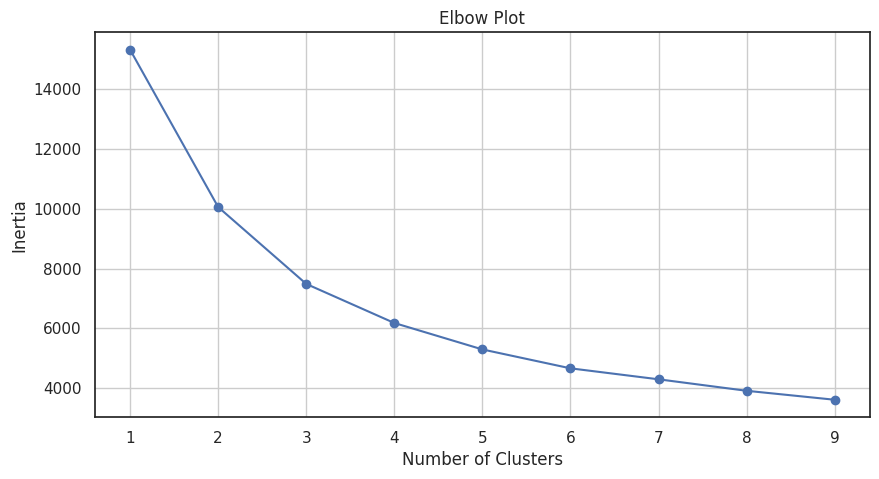

In [ ]:
optimise_k_means(data_km[['Age_T','Severity_T', 'Co-morbidity_Index_T']], 10)

**Conclusion:**
Optimal number of Clusters — 3 (Optional number: 2)

# **Conduct K Means Clustering**

**Choices of number of clusters:**

According to the elbow plot, the optimal number of clusters appears to be **2** and **3**, as there is a sharp change in the rate of decrease at these points.

**Optimal number of clusters: 3**

In [ ]:
number_of_clusters = 3

kmeans = KMeans(n_clusters = number_of_clusters, random_state = 0)
kmeans.fit(data_km)

#Find which cluster each data-point belongs to
clusters = kmeans.predict(data_km)

#Add the cluster information as a new column to our DataFrame
data_km["Cluster"] = clusters

print(data_km.groupby(['Cluster']).sum())

               Age_T   Severity_T  Co-morbidity_Index_T
Cluster                                                
0       -1680.580200  -419.601053          -1516.345797
1        1339.338275 -1213.592933            835.686206
2         341.241925  1633.193986            680.659592


In [ ]:
kmeans = KMeans(n_clusters = 3, random_state = 0)
kmeans.fit(data_km[['Age_T', 'Severity_T','Co-morbidity_Index_T']])

KMeans(n_clusters=3, random_state=0)

In [ ]:
data_km['kmeans_3'] = kmeans.labels_

In [ ]:
plotX = data_km[['Age_T', 'Severity_T','Co-morbidity_Index_T', 'Cluster']]

# Create traces for each cluster
fig = go.Figure()
clusters = plotX['Cluster'].unique()
for cluster in clusters:
    cluster_data = plotX[plotX['Cluster'] == cluster]
    fig.add_trace(go.Scatter3d(
        x=cluster_data['Age_T'],
        y=cluster_data['Severity_T'],
        z=cluster_data['Co-morbidity_Index_T'],
        mode='markers',
        marker=dict(size=5),
        name=f'Cluster {cluster}'
    ))

# Update plot layout
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis_title='Age_T',
        yaxis_title='Severity_T',
        zaxis_title='Co-morbidity_Index_T'
    )
)

fig.show()

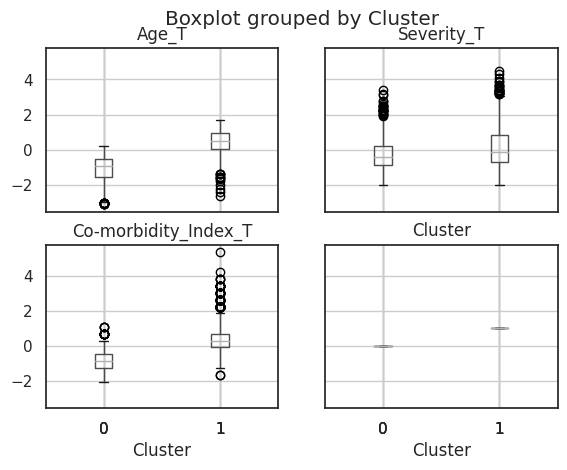

In [ ]:
boxplot = data_km.boxplot(column=['Age_T', 'Severity_T', 'Co-morbidity_Index_T', 'Cluster'], by='Cluster')

**Optional number of clusters: 2**

In [ ]:
number_of_clusters = 2

kmeans = KMeans(n_clusters = number_of_clusters, random_state = 0)
kmeans.fit(data_km)

#Find which cluster each data-point belongs to
clusters = kmeans.predict(data_km)

#Add the cluster information as a new column to our DataFrame
data_km["Cluster"] = clusters

print(data_km.groupby(['Cluster']).sum())

             Age_T  Severity_T  Co-morbidity_Index_T  kmeans_3
Cluster                                                       
0       -1680.5802 -419.601053          -1516.345797         0
1        1680.5802  419.601053           1516.345797      4816


In [ ]:
kmeans = KMeans(n_clusters = 2, random_state = 0)
kmeans.fit(data_km[['Age_T', 'Severity_T', 'Co-morbidity_Index_T']])

KMeans(n_clusters=2, random_state=0)

In [ ]:
data_km['kmeans_2'] = kmeans.labels_

In [ ]:
plotX = data_km[['Age_T', 'Severity_T','Co-morbidity_Index_T', 'Cluster']]

# Create traces for each cluster
fig = go.Figure()
clusters = plotX['Cluster'].unique()
for cluster in clusters:
    cluster_data = plotX[plotX['Cluster'] == cluster]
    fig.add_trace(go.Scatter3d(
        x=cluster_data['Age_T'],
        y=cluster_data['Severity_T'],
        z=cluster_data['Co-morbidity_Index_T'],
        mode='markers',
        marker=dict(size=5),
        name=f'Cluster {cluster}'
    ))

# Update plot layout
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis_title='Age_T',
        yaxis_title='Severity_T',
        zaxis_title='Co-morbidity_Index_T'
    )
)

fig.show()

* Use **BoxPlot to visually look for differences** between columns (For each Cluster):

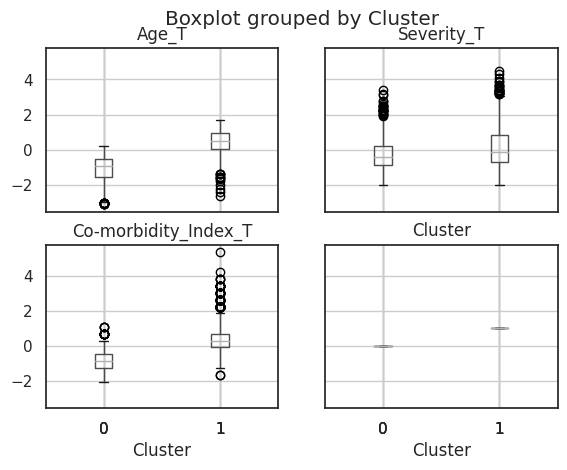

In [ ]:
boxplot = data_km.boxplot(column=['Age_T', 'Severity_T', 'Co-morbidity_Index_T', 'Cluster'], by='Cluster')

**Visualisation using PCA**

Using PCA (Principle Component Analysis) to conduct dimensionality reduction, which can take in a DataFrame with many columns and return a DataFrame with a reduced number of columns that still retains much of the information from the columns of the original DataFrame.

**Note**: The result may not be ideal, but it is saved for future reference.

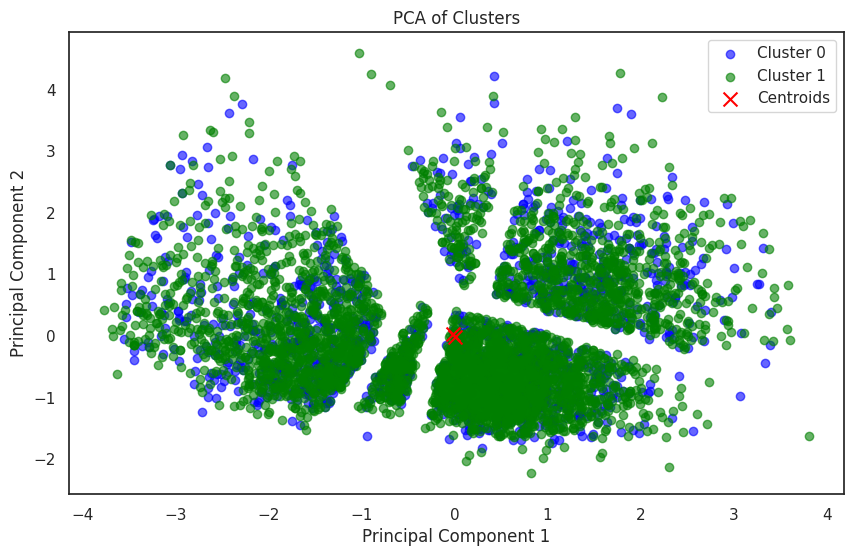

In [ ]:
#plotX is copy of the current DataFrame to be plotted:
plotX = data_km

#PCA with 2 principal components for a 2-D visualisation:
pca_2d = PCA(n_components=2)

#And this DataFrame contains 2 principal components that will aid us
#in visualizing our clusters in
PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["Cluster"], axis=1)))
PCs_2d.columns = ["PC1_2d", "PC2_2d"]


#We concatenate these newly created DataFrames to plotX so that they can be used by plotX as columns.
plotX = pd.concat([plotX,PCs_2d], axis=1, join='inner')

#Now we divide plotX into 2 new DataFrames.
#Each of these new DataFrames will hold all of the values contained in exacltly one of the clusters.

cluster0 = plotX[plotX["Cluster"] == 0]
cluster1 = plotX[plotX["Cluster"] == 1]


## Calculate the mean value (Centroids) for each cluster to be seen in the Plot Figure:

centr = [[cluster0["PC1_2d"].mean(), cluster0["PC2_2d"].mean()],
         [cluster1["PC1_2d"].mean(), cluster1["PC2_2d"].mean()]]

centr_x = [x for x,y in centr]
centr_y = [y for x,y in centr]

# Plot the clusters
plt.figure(figsize=(10, 6))

# Plot Cluster 0
plt.scatter(cluster0["PC1_2d"], cluster0["PC2_2d"], color='blue', label='Cluster 0', alpha=0.6)

# Plot Cluster 1
plt.scatter(cluster1["PC1_2d"], cluster1["PC2_2d"], color='green', label='Cluster 1', alpha=0.6)

# Plot Centroids
plt.scatter(centr_x, centr_y, color='red', marker='x', s=100, label='Centroids')

# Add title and labels
plt.title('PCA of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Show legend
plt.legend()

# Show plot
plt.show()

**Comparison between K = 3 and K = 2:**
- Based on the Elbow method, there is a more substantial decrease in within-cluster sum of squares (WCSS) when moving from 1 to 2 clusters compared to the decrease from 2 to 3 clusters.
- However, the 3-cluster solution provides a clearer separation between groups, offering more interpretable and actionable insights for healthcare staff.

